In [166]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime
import boto3
import botocore
import pprint
import psycopg2
import configparser
import sql_queries1 # contiene las tablas del modelo relacional
import mysql.connector as mysqlC
import pymysql
import io
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image

# Enlace para ver el video

https://www.youtube.com/watch?v=ftsdr2yDKx4

### Carga de datos a AWS - Tienda de productos

> __Tabla de dimensión de productos__: Esta tabla contiene información sobre los productos que se venden en la tienda, como su nombre, descripción, categoría, entre otros. Cada registro en esta tabla representa un producto único y se identifica de forma única por su clave principal.

>__Tabla de detalle de ventas__: Esta tabla contiene información detallada sobre cada venta realizada en la tienda, como el producto comprado, la cantidad, el precio de venta, el descuento aplicado, entre otros. Cada registro en esta tabla representa un artículo específico comprado por un cliente y se identifica de forma única por su clave principal.

>__Tabla de encabezados de ventas__: Esta tabla contiene información general sobre cada venta, como la fecha y hora de la venta, el total de la venta, la forma de pago, el empleado que realizó la venta, entre otros. Cada registro en esta tabla representa una venta única y se identifica de forma única por su clave principal.

>__Tabla de clientes__: Esta tabla contiene información sobre los clientes de la tienda, como su ID, dirección, territorio, entre otros. Cada registro en esta tabla representa un cliente único y se identifica de forma única por su clave principal.

>__Tabla de regiones y país__: Esta tabla contiene información sobre las regiones y países en los que la tienda opera, como el nombre de la región o país. Cada registro en esta tabla representa una región o país único y se identifica de forma única por su clave principal.

>Cada una de estas tablas se relaciona entre sí mediante claves foráneas, lo que permite hacer consultas complejas y obtener información valiosa sobre las ventas, los clientes, los productos y la operación de la tienda en general.

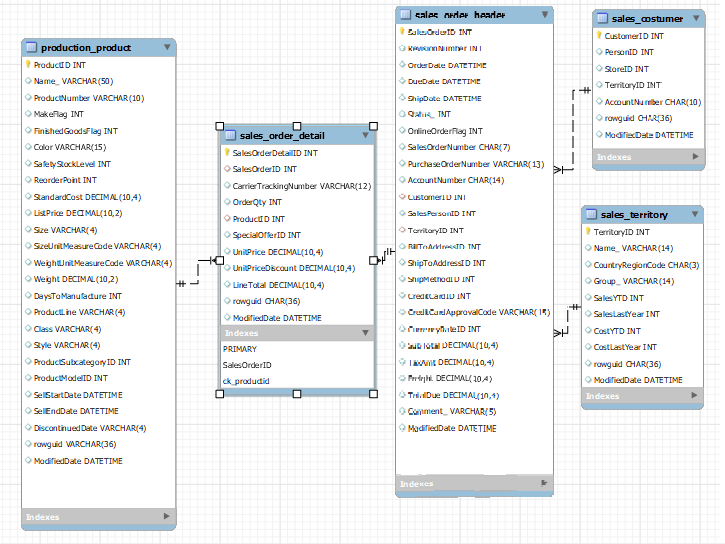

In [167]:
Image("diagramarelacional.png")

#### Creación de instancias en RDS para MySQL

In [20]:
def creacion_instancia(credenciales, name_db ):
    config = configparser.ConfigParser()
    config.read(credenciales)
    
    aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                            aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                            region_name='us-east-1')
    
    rdsInstanceIds = []

    response = aws_conn.describe_db_instances()
    for resp in response['DBInstances']:
        rdsInstanceIds.append(resp['DBInstanceIdentifier'])
        db_instance_status = resp['DBInstanceStatus']
        
    # print(f"DBInstanceIds {rdsInstanceIds}")
    
    rdsIdentifier = name_db
    
    try:
        response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS_MYSQL', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="mysql",
            MasterUsername=config.get('RDS_MYSQL', 'DB_USER'),
            MasterUserPassword=config.get('RDS_MYSQL', 'DB_PASSWORD'),
            Port=int(config.get('RDS_MYSQL', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True)
        #print(response)
    except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
        print("La Instancia de Base de Datos ya Existe.")
    

In [21]:
creacion_instancia('escec.cfg', 'db-proyecto-final')

#### Creación de las tablas del modelo relacional

In [28]:
def db_tables_create( name_db):
    rdsIdentifier = name_db

    try:
        instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
        RDS_DW_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
        print(RDS_DW_HOST)
    except Exception as ex:
        print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
        print(ex)
        
    try:
        myDw = mysqlC.connect(
        host=RDS_DW_HOST, 
        user=config.get('RDS_MYSQL', 'DB_USER'),
        password=config.get('RDS_MYSQL', 'DB_PASSWORD'),
        database=config.get('RDS_MYSQL', 'DB_NAME')
        )

        mycursor = myDw.cursor()
        mycursor.execute(sql_queries1.CREATE_DW, multi=True)
        #myDw.commit()
        print("Data Warehouse Creado Exitosamente")
    except Exception as ex:
        print("ERROR: Error al crear la base de datos.")
        print(ex)

In [29]:
db_tables_create('db-proyecto-final')

db-proyecto-final.cqkkikw8lu3j.us-east-1.rds.amazonaws.com
Data Warehouse Creado Exitosamente


#### Abrir base de datos

In [115]:
RDS_DW_HOST = "db-proyecto-final.cqkkikw8lu3j.us-east-1.rds.amazonaws.com"
config = configparser.ConfigParser()
config.read('escec.cfg')
mysql_driver = f"""mysql+pymysql://{config.get('RDS_MYSQL', 'DB_USER')}:{config.get('RDS_MYSQL', 'DB_PASSWORD')}@{RDS_DW_HOST}:{config.get('RDS_MYSQL', 'DB_PORT')}/{config.get('RDS_MYSQL', 'DB_NAME')}"""

#### Lectura de archivos a cargar

##### Productos

In [30]:
def product(data):
    product = pd.read_excel(data)
    product['DiscontinuedDate'] = pd.to_datetime( product['DiscontinuedDate'])
    product['ProductSubcategoryID'] =  product['ProductSubcategoryID'].replace("NULL", np.nan).astype('Int64')
    product['ProductModelID'] =  product['ProductModelID'].replace("nan", np.nan).astype(float).astype('Int64')
    product = product.rename(columns = {"Name":"Name_" })
    return pd.DataFrame(product)

> Cargando archivos de productos


In [28]:
 # Production.Product
product("table1.xlsx")\
.to_sql('production_product', mysql_driver, index=False, if_exists='append')

504

##### Clientes

In [39]:
def clientes(data ):
    df = pd.read_excel(data)
    df["PersonID"] = df["PersonID"].astype('Int64')
    df["StoreID"] = df["StoreID"].astype('Int64')
    
    return pd.DataFrame(df)

> Cargando archivos de clientes

In [42]:
 # Sales.Customer
clientes("table2.xlsx")\
.to_sql('sales_costumer', mysql_driver, index=False, if_exists='append')

19820

##### Sales Territory

In [49]:
def territory(data):
    df = pd.read_excel(data)
    df = df.rename(columns = {"Name": "Name_", "Group": "Group_"})
    return pd.DataFrame(df)


> cargando archivos de territorio

In [51]:
# Sales.SalesTerritory
territory("table5.xlsx")\
.to_sql('sales_territory', mysql_driver, index=False, if_exists='append')

10

##### Ventas encabezado

In [65]:
def sales_header(data):
    df = pd.read_excel(data) # Sales.SalesOrderHeader
    df = df.rename(columns = {"Status": "Status_","Comment": "Comment_" })
    df["SalesPersonID"] = df["SalesPersonID"].astype('Int64')
    df["CreditCardID"] = df["CreditCardID"].astype('Int64')
    df["CurrencyRateID"] = df["CurrencyRateID"].astype('Int64')
    df["Comment_"] = df["Comment_"].astype(str)
    return pd.DataFrame(df)
    

> Cargando archivos de las ventas encabezado

In [66]:
# Sales.SalesOrderHeader
sales_header("table4.xlsx")\
.to_sql('fact_sales_order_header', mysql_driver, index=False, if_exists='append')


31465

##### Detalle de ventas

In [72]:
def sales_detail(data):
    df = pd.read_excel(data)
    return pd.DataFrame(df)

> Cargando archivos de los detalles de ventas

In [73]:
# Sales.SalesOrderDetail
sales_detail("table3.xlsx")\
.to_sql('sales_order_detail', mysql_driver, index=False, if_exists='append')

121317

#### Lectura de Archivos desde S3

In [135]:
def file_s3(bucket,x,y):
    config = configparser.ConfigParser()
    config.read('escec.cfg')
    s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY'))
    
    S3_BUCKET_NAME = bucket
    
    remoteFileList = []
    for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
        remoteFileList.append(objt.key)

    for remoteFile in remoteFileList[x:y]:
        try:
            file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
            data = file['Body'].read()
            df = pd.read_excel(io.BytesIO(data), engine='openpyxl')
        except Exception as ex:
            #print("No es un archivo.")
            print(ex)
    return df

In [139]:
# Utilizado con la tabla sales fact sales header
s3_1 = file_s3('mybucketlpocon',1,2 )
s3_1

,ShipMethodID,pagos
0,1,Efectivo
1,5,Credito


In [141]:
# utilizado con la tabla territory
s3_2 = file_s3('mybucketlpocon', 2,3)
s3_2

,Status_,Tipo
0,1,En procesos
1,2,Aprobado
2,3,Atrasado
3,4,Rechazado
4,5,Enviados
5,6,Cancelados


#### Obtención de los queries para el análisis de datos

In [3]:
def query(queries):
    RDS_DW_HOST = "db-proyecto-final.cqkkikw8lu3j.us-east-1.rds.amazonaws.com"
    config = configparser.ConfigParser()
    config.read('escec.cfg')
    mysql_driver = f"""mysql+pymysql://{config.get('RDS_MYSQL', 'DB_USER')}:{config.get('RDS_MYSQL', 'DB_PASSWORD')}@{RDS_DW_HOST}:{config.get('RDS_MYSQL', 'DB_PORT')}/{config.get('RDS_MYSQL', 'DB_NAME')}"""
    sql_query = queries
    df = pd.read_sql(sql_query, mysql_driver)
    return df

In [4]:
df_st = query('SELECT * FROM sales_territory;')
df_sc = query('SELECT * FROM sales_costumer;')
df_pp = query('SELECT * FROM production_product;')
df_soh = query('SELECT * FROM fact_sales_order_header;')
df_sod = query('SELECT * FROM sales_order_detail;')

#### Análisis de datos

In [5]:
df_p = df_sod.merge(df_pp, on = ["ProductID"] ,how="inner")\
    .groupby( by= ["SalesOrderID", "Name_"],as_index=False)\
    .agg(Monto= ('LineTotal', 'sum'))\
    .merge(df_soh, on = "SalesOrderID")

In [6]:
products = df_p.groupby("Name_",as_index=False).agg(monto = ("Monto", "sum")).sort_values("monto", ascending = False)
top = products[1:11].reset_index(drop = True )

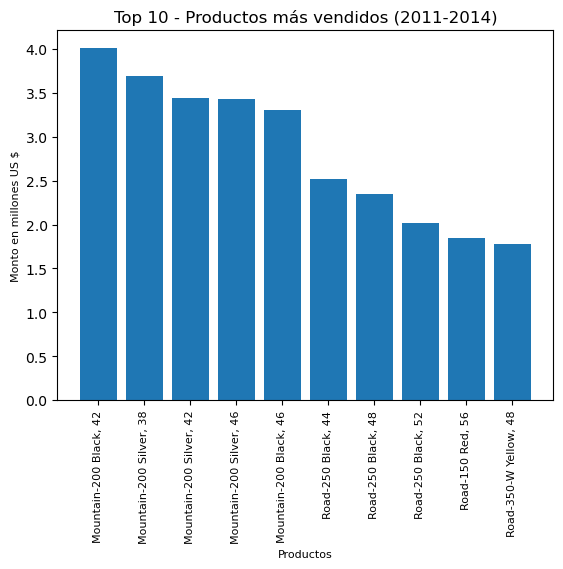

In [11]:
fig, ax = plt.subplots()
ax.bar(top["Name_"], top['monto']/1000000)
ax.set_title("Top 10 - Productos más vendidos (2011-2014)" )
ax.set_xlabel("Productos", fontsize=8)
ax.set_ylabel("Monto en millones US $", fontsize=8)
plt.xticks(fontsize=8)
plt.xticks(rotation=90, fontsize=8)
plt.show() 

In [38]:
df_soh["OrderDate"] = df_soh["OrderDate"].astype(str)
df_soh["anio"] = pd.Series(df_soh["OrderDate"].str[0:4])
df_soh["mes"] = pd.Series(df_soh["OrderDate"].str[5:7])
df_soh["montoTotal"] = df_soh["SubTotal"] + df_soh["TaxAmt"]

In [61]:
com =df_soh.groupby(by=["anio","mes"], as_index=False).agg(monto_total = ("montoTotal", "sum"),costo_trans = ("Freight", "sum")  )
com["dia"] = 1
com["fecha"] =  com["anio"].astype(str) +"-"+com["mes"].astype(str)+"-"+com["dia"].astype(str)

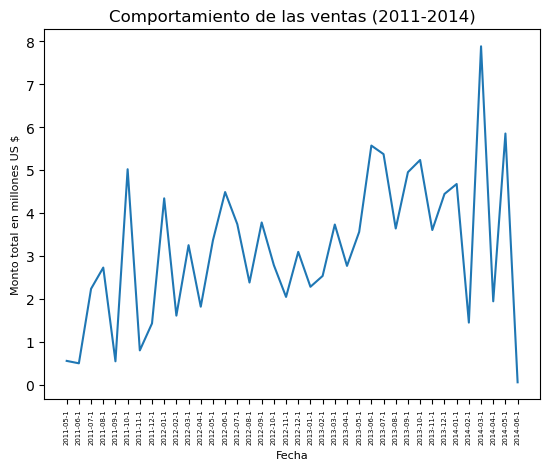

In [56]:
fig, ax = plt.subplots()
ax.plot(com["fecha"],com["monto_total"]/1000000 )
ax.set_title("Comportamiento de las ventas (2011-2014)" )
ax.set_xlabel("Fecha", fontsize=8)
ax.set_ylabel("Monto total en millones US $", fontsize=8)
plt.xticks(fontsize=8)
plt.xticks(rotation=90, fontsize=5)
plt.show()

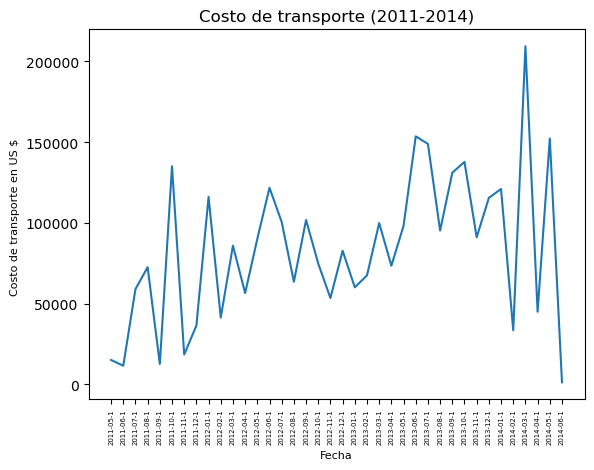

In [65]:
fig, ax = plt.subplots()
ax.plot(com["fecha"],com["costo_trans"] )
ax.set_title("Costo de transporte (2011-2014)" )
ax.set_xlabel("Fecha", fontsize=8)
ax.set_ylabel("Costo de transporte en US $ ", fontsize=8)
plt.xticks(fontsize=8)
plt.xticks(rotation=90, fontsize=5)
plt.show()

In [85]:
ster= df_soh.merge( df_st, on = "TerritoryID", how= "inner")


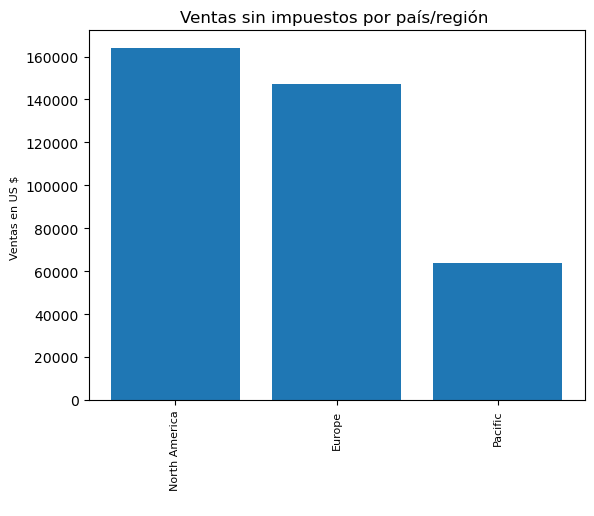

In [86]:
fig, ax = plt.subplots()
ax.bar(ster["Group_"],ster["SubTotal"], label= ster["Group_"])
ax.set_title("Ventas sin impuestos por país/región (2011-2014) " )
ax.set_xlabel(" ", fontsize=8)
ax.set_ylabel("Ventas en US $ ", fontsize=8)
plt.xticks(fontsize=8)
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [103]:
var = []
fecha = []
for i in range(12,len(com)):
    var.append( ((com["monto_total"][i]/com["monto_total"][i-12])-1)*100 )
    fecha.append(com["fecha"][i])
df_variaciones = pd.DataFrame()
df_variaciones["fecha"] = pd.Series(fecha)
df_variaciones["variacion"] = pd.Series(var)

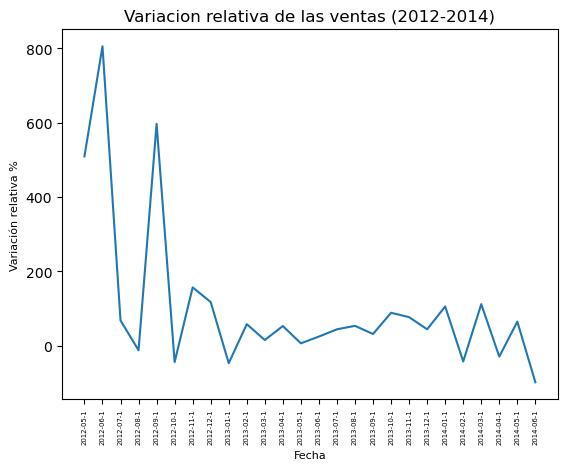

In [106]:
fig, ax = plt.subplots()
ax.plot(df_variaciones["fecha"],df_variaciones["variacion"] )
ax.set_title("Variacion relativa de las ventas (2012-2014)" )
ax.set_xlabel("Fecha", fontsize=8)
ax.set_ylabel("Variación relativa %", fontsize=8)
plt.xticks(fontsize=8)
plt.xticks(rotation=90, fontsize=5)
plt.show()

In [144]:
status = ster.merge(s3_2, on="Status_", how= "inner")

In [160]:
status_ = status.groupby("Tipo")["Group_"].agg( ["count"] ).reset_index(drop = False)

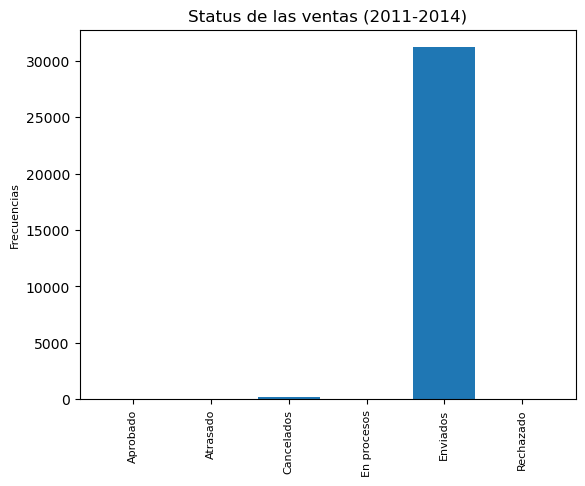

In [164]:
fig, ax = plt.subplots()
ax.bar(status_["Tipo"],status_["count"])
ax.set_title("Status de las ventas (2011-2014)" )
ax.set_xlabel("", fontsize=8)
ax.set_ylabel("Frecuencias", fontsize=8)
plt.xticks(fontsize=8)
plt.xticks(rotation=90, fontsize=8)
plt.show()